### Use bonus plates (length of 4)

In [2]:
import pandas as pd
import random as rd
import numpy as np
import qgrid

from keras.layers import Input, Add, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D
from keras.models import Model, load_model, Sequential

import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
%pylab inline

Using TensorFlow backend.


Populating the interactive namespace from numpy and matplotlib


In [3]:
#
# Definitions
#
# RED = 0.2
# GREEN = 0.4
# BLUE = 0.6
# PURPLE = 0.8
#
colors = [0.2, 0.4, 0.6, 0.8]

moves = {1: ((0, 0), (1, 0)), 2: ((0, 1), (1, 1)), 3: ((0, 2), (1, 2)), 4: ((0, 3), (1, 3)), 5: ((0, 4), (1, 4)), 
         6: ((0, 5), (1, 5)), 7: ((1, 0), (2, 0)), 8: ((1, 0), (0, 0)), 9: ((1, 1), (2, 1)), 10: ((1, 1), (0, 1)), 
         11: ((1, 2), (2, 2)), 12: ((1, 2), (0, 2)), 13: ((1, 3), (2, 3)), 14: ((1, 3), (0, 3)), 15: ((1, 4), (2, 4)), 
         16: ((1, 4), (0, 4)), 17: ((1, 5), (2, 5)), 18: ((1, 5), (0, 5)), 19: ((2, 0), (3, 0)), 20: ((2, 0), (1, 0)), 
         21: ((2, 1), (3, 1)), 22: ((2, 1), (1, 1)), 23: ((2, 2), (3, 2)), 24: ((2, 2), (1, 2)), 25: ((2, 3), (3, 3)), 
         26: ((2, 3), (1, 3)), 27: ((2, 4), (3, 4)), 28: ((2, 4), (1, 4)), 29: ((2, 5), (3, 5)), 30: ((2, 5), (1, 5)), 
         31: ((3, 0), (4, 0)), 32: ((3, 0), (2, 0)), 33: ((3, 1), (4, 1)), 34: ((3, 1), (2, 1)), 35: ((3, 2), (4, 2)), 
         36: ((3, 2), (2, 2)), 37: ((3, 3), (4, 3)), 38: ((3, 3), (2, 3)), 39: ((3, 4), (4, 4)), 40: ((3, 4), (2, 4)), 
         41: ((3, 5), (4, 5)), 42: ((3, 5), (2, 5)), 43: ((4, 0), (5, 0)), 44: ((4, 0), (3, 0)), 45: ((4, 1), (5, 1)), 
         46: ((4, 1), (3, 1)), 47: ((4, 2), (5, 2)), 48: ((4, 2), (3, 2)), 49: ((4, 3), (5, 3)), 50: ((4, 3), (3, 3)), 
         51: ((4, 4), (5, 4)), 52: ((4, 4), (3, 4)), 53: ((4, 5), (5, 5)), 54: ((4, 5), (3, 5)), 55: ((5, 0), (6, 0)), 
         56: ((5, 0), (4, 0)), 57: ((5, 1), (6, 1)), 58: ((5, 1), (4, 1)), 59: ((5, 2), (6, 2)), 60: ((5, 2), (4, 2)), 
         61: ((5, 3), (6, 3)), 62: ((5, 3), (4, 3)), 63: ((5, 4), (6, 4)), 64: ((5, 4), (4, 4)), 65: ((5, 5), (6, 5)), 
         66: ((5, 5), (4, 5)), 67: ((6, 0), (5, 0)), 68: ((6, 1), (5, 1)), 69: ((6, 2), (5, 2)), 70: ((6, 3), (5, 3)), 
         71: ((6, 4), (5, 4)), 72: ((6, 5), (5, 5)), 73: ((0, 0), (0, 1)), 74: ((1, 0), (1, 1)), 75: ((2, 0), (2, 1)), 
         76: ((3, 0), (3, 1)), 77: ((4, 0), (4, 1)), 78: ((5, 0), (5, 1)), 79: ((6, 0), (6, 1)), 80: ((0, 1), (0, 0)), 
         81: ((0, 1), (0, 2)), 82: ((1, 1), (1, 0)), 83: ((1, 1), (1, 2)), 84: ((2, 1), (2, 0)), 85: ((2, 1), (2, 2)), 
         86: ((3, 1), (3, 0)), 87: ((3, 1), (3, 2)), 88: ((4, 1), (4, 0)), 89: ((4, 1), (4, 2)), 90: ((5, 1), (5, 0)), 
         91: ((5, 1), (5, 2)), 92: ((6, 1), (6, 0)), 93: ((6, 1), (6, 2)), 94: ((0, 2), (0, 1)), 95: ((0, 2), (0, 3)), 
         96: ((1, 2), (1, 1)), 97: ((1, 2), (1, 3)), 98: ((2, 2), (2, 1)), 99: ((2, 2), (2, 3)), 100: ((3, 2), (3, 1)), 
         101: ((3, 2), (3, 3)), 102: ((4, 2), (4, 1)), 103: ((4, 2), (4, 3)), 104: ((5, 2), (5, 1)), 105: ((5, 2), (5, 3)), 
         106: ((6, 2), (6, 1)), 107: ((6, 2), (6, 3)), 108: ((0, 3), (0, 2)), 109: ((0, 3), (0, 4)), 110: ((1, 3), (1, 2)), 
         111: ((1, 3), (1, 4)), 112: ((2, 3), (2, 2)), 113: ((2, 3), (2, 4)), 114: ((3, 3), (3, 2)), 115: ((3, 3), (3, 4)), 
         116: ((4, 3), (4, 2)), 117: ((4, 3), (4, 4)), 118: ((5, 3), (5, 2)), 119: ((5, 3), (5, 4)), 120: ((6, 3), (6, 2)), 
         121: ((6, 3), (6, 4)), 122: ((0, 4), (0, 3)), 123: ((0, 4), (0, 5)), 124: ((1, 4), (1, 3)), 125: ((1, 4), (1, 5)), 
         126: ((2, 4), (2, 3)), 127: ((2, 4), (2, 5)), 128: ((3, 4), (3, 3)), 129: ((3, 4), (3, 5)), 130: ((4, 4), (4, 3)), 
         131: ((4, 4), (4, 5)), 132: ((5, 4), (5, 3)), 133: ((5, 4), (5, 5)), 134: ((6, 4), (6, 3)), 135: ((6, 4), (6, 5)), 
         136: ((0, 5), (0, 4)), 137: ((1, 5), (1, 4)), 138: ((2, 5), (2, 4)), 139: ((3, 5), (3, 4)), 140: ((4, 5), (4, 4)), 
         141: ((5, 5), (5, 4)), 142: ((6, 5), (6, 4))}

In [4]:
def color_fits(field, i, j, new_color):
    """
    Checks if two items to the left or two colors to the top are NOT of the same color as the new item.
    Input:
    - field: battfield, numpy array
    - i, j: position on the new item, int, within field.shape
    - new_color: color of the new item, float
    Output:
    - boolean: True, if the new item is ok
    """
    # Check two colors to the left
    if (j > 1):
        if (round(field[i, j - 2] % 1.0, 1) == new_color) and (round(field[i, j - 1] % 1.0, 1) == new_color):
            return False
        
    # Check two colors to the right
    if (j < 4):
        if (round(field[i, j + 2] % 1.0, 1) == new_color) and (round(field[i, j + 1] % 1.0, 1) == new_color):
            return False
    
    # Check two color to the top
    if (i < 5):
        if (round(field[i + 2, j] % 1.0, 1) == new_color) and (round(field[i + 1, j] % 1.0, 1) == new_color):
            return False
    
    return True

In [5]:
def initialize_field(field):
    """
    Initialization of the battle field.
    Move from bottom left corner and add new elements.
    Input: 
    - field: numpy array of zeros, 7x6
    Output:
    - field: numpy array of floats, 7x6
    """
    colors = [0.2, 0.4, 0.6, 0.8]
    
    for i in list(range(field.shape[0]))[::-1]:
        for j in range(field.shape[1]):
            rd.seed()
            new_color = rd.choice(colors)
            
            while not color_fits(field, i, j, new_color):
                rd.seed()
                new_color = rd.choice(colors)
                
            field[i, j] = new_color
    
    return field

In [6]:
def visualize_field(field):
    """
    Visualizes the battle field in colored circles
    Handles bonus plates
    Input:
    - field: numpy array of floats, 7x6
    Output:
    - None
    """
    fig, ax = plt.subplots(figsize=(5, 7))

    ax.set_xlim((0, 10))
    ax.set_ylim((0, 13))

    circles = []

    for ii in range(7):
        for jj in range(6):
            if (round(field[ii, jj] % 1.0, 1) == 0.2):
                clr = "red"
            elif (round(field[ii, jj] % 1.0, 1) == 0.4):
                clr = "lightgreen"
            elif (round(field[ii, jj] % 1.0, 1) == 0.6):
                clr = "cyan"
            else:
                clr = "purple"

            #if (field[ii, jj] // 1 == 1.0):
            #    circles.append( mpatches.RegularPolygon((jj + 1, 7 - ii), numVertices=4, radius=0.4, color=clr) )
            #else:
            #    circles.append( mpatches.Circle((jj + 1, 7 - ii), radius=0.4, color=clr) )
             
            #
            # DEBUG
            #
            if (field[ii, jj] == 0.0):
                circles.append( mpatches.RegularPolygon((jj + 1, 7 - ii), numVertices=3, radius=0.2, color="black") )
            elif (field[ii, jj] // 1 == 1.0):
                circles.append( mpatches.RegularPolygon((jj + 1, 7 - ii), numVertices=4, radius=0.4, color=clr) )
            else:
                circles.append( mpatches.Circle((jj + 1, 7 - ii), radius=0.4, color=clr) )


    for circ in circles:
        ax.add_artist(circ)
        
    return

In [7]:
def plate_in_set(plate, row, col, length, direction):
    """
    Checks whether plate is with the set given by row, col, length, direction
    Input:
    - plate: plate location, tuple (row, column)
    - row: row where the set starts
    - col: column where the set starts
    - length: the set's length
    - direction: the set's direction
    Output:
    - True if the plate is within the set, False otherwise
    """
    if (direction == 0):
        # Horizontal set
        if ((plate[0] != row) or (plate[1] < col) or (plate[1] > (col + length - 1))):
            return False
    else:
        # Vertucal set
        if ((plate[1] != col) or (plate[0] < row) or (plate[0] > (row + length - 1))):
            return False
        
    return True

In [8]:
def fill_field(field, colors):
    """
    Наполняет поле после сжигания рядов.
    Сдвигает фишки вниз, заполняя верхний ряд каждый раз так, чтобы верхний ряд не создавал халявной тройки
    Начинает с левого нижнего угла, чтобы переиспользовать color_fits()
    Input:
    - field: numpy array of floats, 7x6
    - colors: list of 4 floats - color values, see the definition above
    Output:
    - numpy array of floats, 7x6 - updated field
    """
    for ii in list(range(7))[::-1]:
        for jj in range(6):
            while (field[ii, jj] == 0.):
                # Опускаем на один вниз
                # Если мы в самом верхнем ряду, то опускать не нужно
                if (ii != 0):
                    for iii in list(range(1, ii + 1))[::-1]:
                        field[iii, jj] = field[iii - 1, jj]

                # Заполняем верх
                new_color = rd.choice(colors)

                while not color_fits(field, 0, jj, new_color):
                    new_color = rd.choice(colors)

                field[0, jj] = new_color  
                
    return field

In [9]:
def make_move_v2(field, move, moves):
    """
    Physically moves plates according to the move
    Input:
    - field: numpy array of floats, 7x6
    - move: particular move to make, 1<=move<=142
    - moves: dictionary of all possible moves defined above
    Output:
    - new_field: updated field with two swapped plates
    - plate_start: coordinates of the plate that started the move, tuple (row, column)
    - plate_end: cooredinates of the plate that ended the move, tuple (row, column)
    """
    (start_row, start_col), (end_row, end_col) = moves[move]

    # Swap two plates and create new (modified) field
    new_field = np.array(field)
    temp_color = field[end_row, end_col]
    new_field[end_row, end_col] = field[start_row, start_col]
    new_field[start_row, start_col] = temp_color
        
    return new_field, (start_row, start_col), (end_row, end_col)

In [10]:
def get_sets(field):
    """
    Finds all sets and all bonus plates included into those sets
    Input:
    - field: numpy array of floats, 7x6
    Output:
    - list of sets coordinates: list of tuples (row_start, column_start, set_length, direction, color), counting from top left corner
      Direction is either 0 (horizontal) or 1 (vertical)
    - list of bonus plates included into sets: list of tuples (row, column, type). 
      Type is either 4 or 5 (reserved for future)
    """
    perm_bonus_plates = []
    perm_sets = []

    # Find all 3+ sets in horizontal row
    for ii in range(field.shape[0]):
        temp_bonus_plates = []
        jj = 0
        len = 1
        while (jj < field.shape[1]):
            if (jj > 0):
                if (round(field[ii, jj] % 1.0, 1) == round(field[ii, jj - 1] % 1.0, 1)):
                    len = len + 1
                else:
                    if (len >= 3):
                        # Add temp list of bonus plates to the permanent list of bonus plates
                        perm_bonus_plates = perm_bonus_plates + temp_bonus_plates
                        
                        # Add to permanent list of sets
                        perm_sets.append((ii, jj - len, len, 0, round(field[ii, jj - 1] % 1, 1)))
                        
                    temp_bonus_plates = []
                    len = 1
            
            if (field[ii, jj] > 1.):
                # Add to temp list of bonus plates
                temp_bonus_plates.append((ii, jj, 4))
            
            jj = jj + 1
            
        if (len >= 3):
            # Add temp list of bonus plates to the permanent list of bonus plates
            perm_bonus_plates = perm_bonus_plates + temp_bonus_plates

            # Add to permanent list of sets
            perm_sets.append((ii, jj - len, len, 0, round(field[ii, jj - 1] % 1, 1)))

    # Find all 3+ sets in vertical columns
    for jj in range(field.shape[1]):
        temp_bonus_plates = []
        ii = 0
        len = 1
        while (ii < field.shape[0]):
            if (ii > 0):
                if (round(field[ii, jj] % 1.0, 1) == round(field[ii - 1, jj] % 1, 1)):
                    len = len + 1
                else:
                    if (len >= 3):
                        # Add temp list of bonus plates to the permanent list of bonus plates
                        perm_bonus_plates = perm_bonus_plates + temp_bonus_plates
                        
                        # Add to permanent list of sets
                        perm_sets.append((ii - len, jj, len, 1, round(field[ii - 1, jj] % 1, 1)))
                        
                    temp_bonus_plates = []
                    len = 1
            
            if (field[ii, jj] > 1.):
                # Add to temp list of bonus plates
                temp_bonus_plates.append((ii, jj, 4))
            
            ii = ii + 1
            
        if (len >= 3):
            # Add temp list of bonus plates to the permanent list of bonus plates
            perm_bonus_plates = perm_bonus_plates + temp_bonus_plates

            # Add to permanent list of sets
            perm_sets.append((ii - len, jj, len, 1, round(field[ii - 1, jj] % 1, 1)))
            
    return perm_sets, perm_bonus_plates

In [11]:
def calculate_score_v2(field, plate_from, plate_to):
    """
    Calculates the score in the field. 
    Replaces all sets with zeros.
    Handles bonus plates: replaces required rows with zeros (Type 4)
    Puts bonus plates, should any set be of the length of 4
    Input:
    - field: numpy array of floats, 7x6
    - plate_from: coordinates of the plate where the move starts, tuple (row, column)
    - plate_to: coordinates of the plate where the move ends, tuple (row, column)
    Output:
    - score: int, 0+
    - field: modified field
    """
    # Get all sets with possible bonus plates
    sets, bonus_plates = get_sets(field)

    # Set all requires plates to zero
    #
    # First handle sets
    for st in sets:
        row = st[0]
        col = st[1]
        lng = st[2]
        drc = st[3]

        if (drc == 0):
            field[row, col:(col + lng)] = 0
        else:
            field[row:(row + lng), col] = 0
    #       
    # Then handle bonus plates/rows
    for pl in bonus_plates:
        row = pl[0]
        col = pl[1]
        typ = pl[2]

        if (typ == 4):
            field[row, :] = 0

    # Calculate score
    score = (field == 0.).sum()

    # Put new bonus plates. Specially care for the move coordinates
    for st in sets:
        row = st[0]
        col = st[1]
        lng = st[2]
        drc = st[3]
        clr = st[4]

        if (lng >= 4):
            if (plate_in_set(plate_from, row, col, lng, drc)):
                # Move start plate in set. Put new bonus plate according to the move coordinates
                field[plate_from[0], plate_from[1]] = clr + 1.0
                
                #
                # DEBUG
                #
                #print("DEBUG: set of 4+ was made!")
                
            elif (plate_in_set(plate_to, row, col, lng, drc)):
                # Move end plate in set. Put new bonus plate according to the move coordinates
                field[plate_to[0], plate_to[1]] = clr + 1.0
                
                #
                # DEBUG
                #
                #print("DEBUG: set of 4+ was made!")
                
            else:
                # Just put the new bonus plate at the very right/bottom of the set
                # This CANNOT happen during the manual move!
                # It CAN ONLY HAPPEN when the field is randomly filled with new plates
                if (drc == 0):
                    field[row, col + lng - 1] = clr + 1.0
                else:
                    field[row + lng - 1, col] = clr + 1.0

    return score, field

In [23]:
def predict_max_score(field, aero_cnn, number_of_moves, moves, debug_flag = False):
    """
    TODO 
    """
    X_data = ()
           
    for move in range(1, number_of_moves + 1):
        swapped, _, _ = make_move_v2(np.array(field), move, moves)
        X_data = X_data + ( swapped, )
    
    # Теперь выбираем наиболее успешый ход из всех успешных
    X_data = np.expand_dims(np.stack(X_data, axis=0), axis=3)
    
    prediction = aero_cnn.predict(X_data)
    
    if (debug_flag):
        print("DEBUG", prediction)
    
    best_move_score = prediction.max()
    best_move_number = prediction.argmax() + 1
    
    return best_move_score, best_move_number

## Offline CNN training

### First generate a lot of data

In [13]:
# Variables
moves_memory = []
COUNTER_OF_SUCCESSFUL_MOVES = 0

# Constants
NUMBER_OF_MOVES_IN_GAME = 50
NUMBER_OF_GAMES = 5000

In [14]:
%%time

for g in range(NUMBER_OF_GAMES):
    # Начинаем одну игру
    game_score = 0

    # Initialize the game field
    field = np.zeros((7, 6))
    field = initialize_field(field)

    for m in range(NUMBER_OF_MOVES_IN_GAME):
        # Общий счет хода
        reward = 0
        
        # Randomly select a move
        rd.seed()
        move = rd.choice(list(range(1, 143)))

        # Make the move
        s_before = field
        new_field, plate_a, plate_b = make_move_v2(field, move, moves)

        # Calculate the score and update the field
        score, new_field = calculate_score_v2(new_field, plate_a, plate_b)
        
        # Если ход результативный, то обновляем поле и проверяем, получились ли новые цветовые ряды
        # Пока есть новые цветные ряды, обрабатываем их, обсчитываем и сдвигаем блюда
        successful_move_flag = False

        while (score > 0.):
            if (not successful_move_flag):
                COUNTER_OF_SUCCESSFUL_MOVES = COUNTER_OF_SUCCESSFUL_MOVES + 1
                successful_move_flag = True

            # Суммируем набранные очки
            reward = reward + score

            # Сдвигаем фишки вниз, заполняя верхний ряд каждый раз так, чтобы верхний ряд не создавал халявной тройки
            # Начинаем с левого нижнего угла (чтобы переиспользовать color_fits())
            new_field = fill_field(new_field, colors)

            # Считаем очки и обрабатываем новые возможные цветные ряды
            score, new_field = calculate_score_v2(new_field, (-1, -1), (-1, -1))

        # Если ход успешный, то меняем поле
        if (successful_move_flag):
            field = new_field
            
        # Увеличиваем счет игры
        game_score = game_score + reward
            
        # Сохраняем ход, очки и все состояния в память   
        s_after = field
        moves_memory.append((s_before, move, reward, s_after)) 

print("The number of successful moves is {}".format(COUNTER_OF_SUCCESSFUL_MOVES))

The number of successful moves is 48916
Wall time: 3min 44s


In [15]:
# Проверка, что в случае неуспешного (нулевого) хода начальное и конечное состояния совпадают
for item in moves_memory:
    if (item[2] == 0):
        if ( np.abs(item[0] - item[3]).sum() != 0.  ):
            print("Error!")

In [16]:
# Нужно проредить память ходов, чтобы сделать соотношение успешных и неуспешных ходов примерно 1:1
moves_to_remove = len(moves_memory) - 2 * COUNTER_OF_SUCCESSFUL_MOVES

i = 0

while (i < moves_to_remove):
    elem = rd.randint(0, len(moves_memory) - 1)
    
    if (moves_memory[elem][2] == 0.):
        moves_memory.pop(elem)
        i = i + 1
    else:
        rd.seed()
        
print("{} items cleared from moves_memory".format(moves_to_remove))
print("Final length of moves_memory is", len(moves_memory))

152168 items cleared from moves_memory
Final length of moves_memory is 97832


### Next train the CNN

In [27]:
# Готовим модель
# v6.0 pure Keras 20190323
aero_cnn = Sequential()

aero_cnn.add(Conv2D(192, kernel_size=3, strides = (1, 1), padding='same', activation='relu', data_format = 'channels_last', input_shape=(7, 6, 1)))
aero_cnn.add(Conv2D(128, kernel_size=3, strides = (1, 1), padding='same', activation='relu'))
aero_cnn.add(Flatten())
aero_cnn.add(Dense(64, activation='relu'))
aero_cnn.add(Dense(1))

aero_cnn.compile(optimizer='adam', loss='mean_squared_error', metrics=['mse'])

aero_cnn.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 7, 6, 192)         1920      
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 7, 6, 128)         221312    
_________________________________________________________________
flatten_2 (Flatten)          (None, 5376)              0         
_________________________________________________________________
dense_3 (Dense)              (None, 64)                344128    
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 65        
Total params: 567,425
Trainable params: 567,425
Non-trainable params: 0
_________________________________________________________________


In [28]:
# Constants
NUM_OF_EPOCHS = 500
MINIBATCH_SIZE = 64

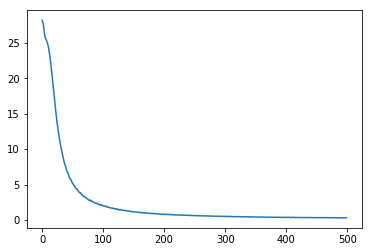

Wall time: 16h 59min 6s


In [29]:
%%time

replay_memory = moves_memory

# Строим X_train и Y_train
X_train = ()
Y_train = np.zeros((len(replay_memory), 1))

for num, item in enumerate(replay_memory):
    s_before = item[0]
    actn = item[1]
    rwrd = item[2]
    s_after = item[3]

    X_train = X_train + (make_move_v2(s_before, actn, moves)[0],)
    Y_train[num, 0] = rwrd

X_train = np.expand_dims(np.stack(X_train, axis=0), axis=3)

# Делаем градиентный спуск, подкручиваем веса сети
history = aero_cnn.fit(X_train, Y_train, batch_size=MINIBATCH_SIZE, epochs=NUM_OF_EPOCHS, verbose=0)

plt.plot(history.history['loss'])
plt.show()

### Debugging, since it doesn't work

In [50]:
cnt = 0
last = 1

for item in replay_memory:
    if (item[2] > 0):
        if (cnt > last):
            break
        else:
            cnt = cnt + 1
        
print(item[2], cnt)

4 2


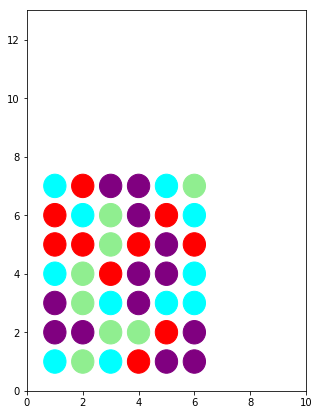

In [51]:
visualize_field(item[0])

In [79]:
moves[103]

((4, 2), (4, 3))

In [66]:
temp_field, plate_from, plate_to = make_move_v2(item[0], 15, moves)
print(plate_from, plate_to)

(1, 4) (2, 4)


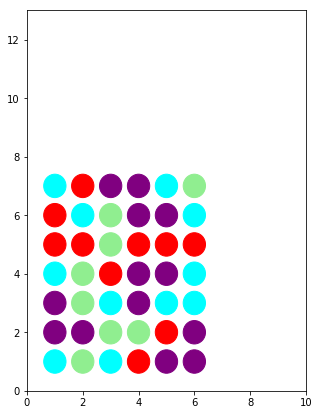

In [67]:
visualize_field(temp_field)

In [68]:
score, temp_field_v2 = calculate_score_v2(temp_field, plate_from, plate_to)
print(score)

3


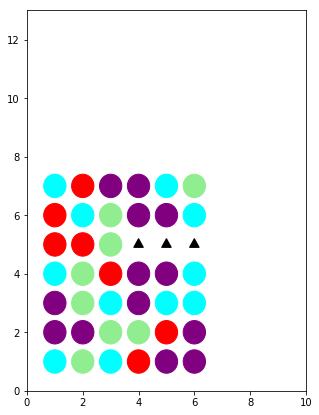

In [69]:
visualize_field(temp_field_v2)

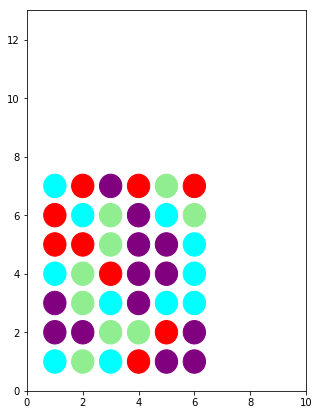

In [70]:
visualize_field(fill_field(temp_field_v2, colors))

0


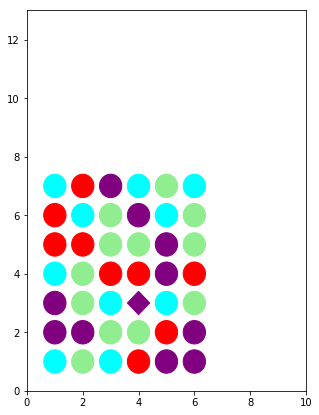

In [77]:
score, temp_field_v3 = calculate_score_v2(temp_field_v2, (-1, -1), (-1, -1))
print(score)
visualize_field(fill_field(temp_field_v3, colors))

In [75]:
X_data = ()

for move in range(1, 142 + 1):
    swapped, _, _ = make_move_v2(np.array(temp_field_v3), move, moves)
    X_data = X_data + ( swapped, )

# Теперь выбираем наиболее успешый ход из всех успешных
X_data = np.expand_dims(np.stack(X_data, axis=0), axis=3)

prediction = aero_cnn.predict(X_data)

print(prediction.max())
print(prediction.argmax() + 1)
print(moves[prediction.argmax() + 1])

10.817631
103
((4, 2), (4, 3))


In [80]:
print(prediction)

[[ 1.2432319 ]
 [-3.942157  ]
 [-0.4027602 ]
 [-0.79147786]
 [-0.32052678]
 [-1.1668216 ]
 [-0.52669924]
 [ 1.2432319 ]
 [ 2.5478966 ]
 [-3.942157  ]
 [-0.52669924]
 [-0.4027602 ]
 [ 1.821803  ]
 [-0.79147786]
 [-1.785205  ]
 [-0.32052678]
 [-0.52669924]
 [-1.1668216 ]
 [-2.5586088 ]
 [-0.52669924]
 [-1.9714123 ]
 [ 2.5478966 ]
 [ 3.481365  ]
 [-0.52669924]
 [-0.48471707]
 [ 1.821803  ]
 [-0.52669924]
 [-1.785205  ]
 [-1.1112    ]
 [-0.52669924]
 [ 0.05783827]
 [-2.5586088 ]
 [-0.52669924]
 [-1.9714123 ]
 [ 0.51449376]
 [ 3.481365  ]
 [ 3.19954   ]
 [-0.48471707]
 [ 0.4469989 ]
 [-0.52669924]
 [-1.3895122 ]
 [-1.1112    ]
 [-0.52669924]
 [ 0.05783827]
 [ 0.49204284]
 [-0.52669924]
 [-1.4192821 ]
 [ 0.51449376]
 [ 8.403596  ]
 [ 3.19954   ]
 [ 1.7137522 ]
 [ 0.4469989 ]
 [ 2.777487  ]
 [-1.3895122 ]
 [-0.7518255 ]
 [-0.52669924]
 [-0.13495366]
 [ 0.49204284]
 [-0.36933583]
 [-1.4192821 ]
 [-2.6444237 ]
 [ 8.403596  ]
 [ 4.2036047 ]
 [ 1.7137522 ]
 [-0.52669924]
 [ 2.777487  ]
 [-0.75182

### Finally, look how CNN can play

In [32]:
NUMBER_OF_GAMES = 10000
MAXIMUM_SCORE = 0

In [33]:
for game in range(NUMBER_OF_GAMES):
    # Начинаем одну игру
    COUNTER_OF_SUCCESSFUL_MOVES = 0
    game_score = 0

    # Initialize the game field
    field = np.zeros((7, 6))
    field = initialize_field(field)

    for m in range(NUMBER_OF_MOVES_IN_GAME):
        # Общий счет хода
        reward = 0
        
        # CNN selects a move
        move = predict_max_score(field, aero_cnn, 142, moves)[1]

        # Make the move
        s_before = field
        new_field, plate_a, plate_b = make_move_v2(field, move, moves)

        # Calculate the score and update the field
        score, new_field = calculate_score_v2(new_field, plate_a, plate_b)
        
        # Если ход результативный, то обновляем поле и проверяем, получились ли новые цветовые ряды
        # Пока есть новые цветные ряды, обрабатываем их, обсчитываем и сдвигаем блюда
        successful_move_flag = False

        while (score > 0.):
            if (not successful_move_flag):
                COUNTER_OF_SUCCESSFUL_MOVES = COUNTER_OF_SUCCESSFUL_MOVES + 1
                successful_move_flag = True

            # Суммируем набранные очки
            reward = reward + score

            # Сдвигаем фишки вниз, заполняя верхний ряд каждый раз так, чтобы верхний ряд не создавал халявной тройки
            # Начинаем с левого нижнего угла (чтобы переиспользовать color_fits())
            new_field = fill_field(new_field, colors)

            # Считаем очки и обрабатываем новые возможные цветные ряды
            score, new_field = calculate_score_v2(new_field, (-1, -1), (-1, -1))

        # Если ход успешный, то меняем поле
        if (successful_move_flag):
            field = new_field
            
        # Увеличиваем счет игры
        game_score = game_score + reward
            
    #
    # Calculate and display overall stats
    #
    # Проверяем, не обновили ли максимум
    if (game_score > MAXIMUM_SCORE):
        print("New maximum: {}".format(game_score))
        MAXIMUM_SCORE = game_score

    print("Game score is {}, the number of successful moves is {}".format(game_score, COUNTER_OF_SUCCESSFUL_MOVES))

New maximum: 16
Game score is 16, the number of successful moves is 2
Game score is 7, the number of successful moves is 2
Game score is 0, the number of successful moves is 0
Game score is 13, the number of successful moves is 2
Game score is 10, the number of successful moves is 1
Game score is 16, the number of successful moves is 2
Game score is 0, the number of successful moves is 0
Game score is 0, the number of successful moves is 0
Game score is 3, the number of successful moves is 1
New maximum: 25
Game score is 25, the number of successful moves is 4
Game score is 13, the number of successful moves is 1
Game score is 4, the number of successful moves is 1
Game score is 0, the number of successful moves is 0
Game score is 0, the number of successful moves is 0
Game score is 6, the number of successful moves is 1
Game score is 9, the number of successful moves is 1
Game score is 0, the number of successful moves is 0
Game score is 3, the number of successful moves is 1
Game sco

KeyboardInterrupt: 

## Dynamic Learning

In [ ]:
# Definitions
GAMES_TO_PLAY = 10000
REPLAY_MEMORY_SIZE = 8192
RANDOM_MOVE_PROB = 0.5
DYNAMIC_LEARNING_EPOCHS = 5

# Variables
MAXIMUM_SCORE = 0
TOTAL_SCORE_100 = 0.0
AVG_SCORE_HIST = []
TOTAL_SUCCESSFUL_MOVES_100 = 0.0
AVG_SUCC_MOVES_HIST = []

# Initialize replay_memory
replay_memory = []

In [ ]:
%%time

for game in range(GAMES_TO_PLAY):
    # Начинаем одну игру
    game_score = 0
    successful_moves = 0

    # Initialize the game field
    field = np.zeros((7, 6))
    field = initialize_field(field)

    for m in range(NUMBER_OF_MOVES_IN_GAME):
        # Общий счет хода
        reward = 0

        # CNN selects a move
        # Пока не будем использовать случайные ходы, хотя так описано в статье
        # Если в replay_memory меньше 64 ходов, то делаем эти ходы случайным образом
        if (len(replay_memory) < MINIBATCH_SIZE):
            move = rd.randint(1, 142) 
        else:
            _, move = predict_max_score(field, aero_cnn, 142, moves)

        # Make the move
        s_before = field
        new_field, plate_a, plate_b = make_move_v2(field, move, moves)

        # Calculate the score and update the field
        score, new_field = calculate_score_v2(new_field, plate_a, plate_b)
        
        # Если ход результативный, то обновляем поле и проверяем, получились ли новые цветовые ряды
        # Пока есть новые цветные ряды, обрабатываем их, обсчитываем и сдвигаем блюда
        successful_move_flag = False

        while (score > 0.):
            if (not successful_move_flag):
                successful_moves = successful_moves + 1
                successful_move_flag = True

            # Суммируем набранные очки
            reward = reward + score

            # Сдвигаем фишки вниз, заполняя верхний ряд каждый раз так, чтобы верхний ряд не создавал халявной тройки
            # Начинаем с левого нижнего угла (чтобы переиспользовать color_fits())
            new_field = fill_field(new_field, colors)

            # Считаем очки и обрабатываем новые возможные цветные ряды
            score, new_field = calculate_score_v2(new_field, (-1, -1), (-1, -1))

        # Увеличиваем счет игры
        game_score = game_score + reward

        #
        # Train CNN based on the score
        #
        if (len(replay_memory) >= MINIBATCH_SIZE):
            # Случайно выбираем 64 хода из памяти
            samples = rd.sample(replay_memory, MINIBATCH_SIZE)
            # Один ход (пусть будет последний) заполняем нашим реальным ходом
            samples[MINIBATCH_SIZE - 1] = (field, move, reward, new_field)

            # Строим X_train и Y_train
            X_train = ()
            Y_train = np.zeros((MINIBATCH_SIZE, 1))

            for num, item in enumerate(samples):
                s_before = item[0]
                actn = item[1]
                rwrd = item[2]
                s_after = item[3]

                X_train = X_train + (make_move_v2(s_before, actn, moves)[0],)
                Y_train[num, 0] = rwrd + GAMMA * predict_max_score(s_after, aero_cnn, 142, moves)[0]

            # 64-й ход - реальный, поэтому для него предсказание будущего не нужно. Ставим фактическое значение
            Y_train[MINIBATCH_SIZE - 1, 0] = rwrd
            # Делаем правильный по размеру тензор
            X_train = np.expand_dims(np.stack(X_train, axis=0), axis=3)
            # Подкручиваем сеть
            aero_cnn.fit(X_train, Y_train, epochs=DYNAMIC_LEARNING_EPOCHS, verbose=0)

            if (len(replay_memory) == REPLAY_MEMORY_SIZE):
                replay_memory.pop(0)

        # Add new move to the replay memory
        replay_memory.append((field, move, reward, new_field))

        # Если ход успешный, то меняем поле
        if (successful_move_flag):
            field = new_field

    #
    # Calculate and display overall stats
    #
    # Проверяем, не обновили ли максимум
    if (game_score > MAXIMUM_SCORE):
        print("New maximum: {}, after {} games.".format(game_score, game))
        MAXIMUM_SCORE = game_score
        
    # После каждой тысячи игр выводим средний балл за игру, среднее число успешных ходов за игру
    TOTAL_SCORE_100 = TOTAL_SCORE_100 + game_score
    TOTAL_SUCCESSFUL_MOVES_100 = TOTAL_SUCCESSFUL_MOVES_100 + successful_moves
    
    if ((game % 100 == 0) and (game > 0)):
        avg_score = TOTAL_SCORE_100 / game
        AVG_SCORE_HIST.append(avg_score)
        TOTAL_SCORE_100 = 0.0
        
        avg_succ_moves = TOTAL_SUCCESSFUL_MOVES_100 / game
        AVG_SUCC_MOVES_HIST.append(avg_succ_moves)
        TOTAL_SUCCESSFUL_MOVES_100 = 0.0

        print("Games played: {}, average score for last 100 games: {}, average number of successful moves: {}".format(game, avg_score, avg_succ_moves))        
        
# По окончании мероприятия посмотрим историю среднего балла
plt.plot(AVG_SCORE_HIST, color='red')
plt.plot(AVG_SUCC_MOVES_HIST, color='blue')
plt.show()

## Test part

In [77]:
#field = np.zeros((7, 6))

df = pd.DataFrame(updated_field)
qgrid_widget = qgrid.show_grid(df, show_toolbar=True)
qgrid_widget

QgridWidget(grid_options={'fullWidthRows': True, 'syncColumnCellResize': True, 'forceFitColumns': True, 'defau…

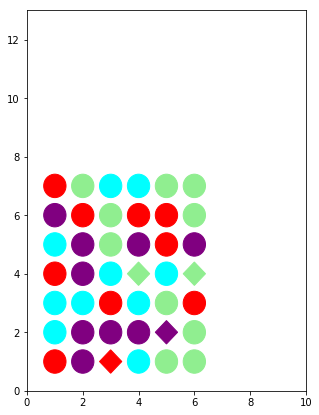

In [79]:
updated_df = qgrid_widget.get_changed_df()
updated_field = updated_df.values
visualize_field(updated_field)

In [80]:
get_sets(updated_field)

([(5, 1, 4, 0, 0.8)], [(5, 4, 4)])

6


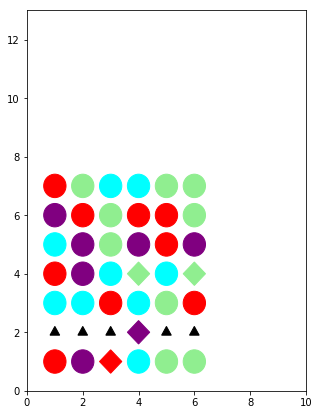

In [81]:
score, new_field = calculate_score_v2(updated_field, (6, 3), (5, 3))
print(score)
visualize_field(updated_field)

In [83]:
#updated_field_2 = fill_field(updated_field, colors)
#visualize_field(updated_field_2)

### Now the CNN has been trained.
### Start the long reinforcement-learning cycle

New maximum: 426.0, after 0 games.


NameError: name 'TOTAL_SUCCESSFUL_MOVES' is not defined

In [45]:
successful_moves

39

In [34]:
new_field = make_move(field, move)
print(new_field)

[[0.8 0.4 0.8 0.4 0.4 0.8]
 [0.2 0.2 0.6 0.8 0.8 0.2]
 [0.4 0.8 0.2 0.6 0.6 0.2]
 [0.4 0.4 0.6 0.8 0.4 0.8]
 [0.2 0.8 0.2 0.4 0.2 0.4]
 [0.6 0.4 0.2 0.4 0.6 0.4]
 [0.2 0.8 0.8 0.8 0.2 0.2]]


In [35]:
temp_field = calculate_score(new_field)

In [36]:
new_field = np.multiply(new_field, 1.0 - temp_field)

In [37]:
fill_field(new_field, colors)

In [23]:
#
# Save model
#
# v1: 20190329, trained on len(replay_memory) = 294912
#aero_cnn.save("Aero_CNN_v1")

## Backup

In [ ]:
#
# Create the moves dictionary
#
moves = {}

for i in range(1, 143):
    old_row, old_column, old_direction = process_move_142(i)
    
    start_row = old_row - 1
    start_col = old_column - 1
    
    if (old_direction == "down"):
        end_row = start_row + 1
        end_col = start_col
    elif (old_direction == "up"):
        end_row = start_row - 1
        end_col = start_col
    elif (old_direction == "right"):
        end_row = start_row
        end_col = start_col + 1
    else:
        end_row = start_row
        end_col = start_col - 1
        
    moves[i] = ((start_row, start_col), (end_row, end_col))
    
print(moves)